In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F
import numpy as np
import cv2
import pickle


# PARAMS

In [3]:
# Parameters for the model
n_pixels = 512*512
n_classes = 10

# Parameters for the training
USE_CPU = False
reg_val = 1e-4
lr = 0.001 / 2
batchsize = 32

# For version control
version_number = 7
spectro_len = 3


# RECREATING DATASET

In [4]:
# Recreating Test Set 

from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[.5], std=[.5])  # Normalize for Grayscale
])
# Rebuild the original dataset
dataset = datasets.ImageFolder(root=f'sliding_spectrograms_{spectro_len}_seconds', transform=transform)

image, label = dataset[0] 
print(image.shape) # torch.Size([1, 28, 28])
print(label) 
input_image_shape = image.shape

# Load indices
train_indices = torch.load(f'train_indices_v{version_number}.pt')
val_indices = torch.load(f'val_indices_v{version_number}.pt')
test_indices = torch.load(f'test_indices_v{version_number}.pt')

# Recreate test subset
trainset = Subset(dataset, train_indices)
valset = Subset(dataset, val_indices)
testset = Subset(dataset, test_indices)

batchsize = 32

# Create DataLoader|
# trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
# train_eval_loader = DataLoader(trainset, batch_size=batchsize, shuffle=False)
# valloader = DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False)

torch.Size([1, 512, 512])
0


# LOADING DATA 

## (WARNING: DO NOT RE-RUN THIS CODE AFTER TRAINING!!! - dataset indices will get overwritten!!!)


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[.5], std=[.5])  # Normalize for Grayscale
])

# --- 2. Load dataset ---
dataset = datasets.ImageFolder(root=f'sliding_spectrograms_{spectro_len}_seconds', transform=transform)


# Split into train, val, test (80/10/10)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
trainset, valset, testset = random_split(dataset, [train_size, val_size, test_size])

#### DO NOT RE-RUN THIS CODE!!!
# torch.save(trainset.indices, f'train_indices_v{version_number}.pt')
# torch.save(valset.indices, f'val_indices_v{version_number}.pt')
# torch.save(testset.indices, f'test_indices_v{version_number}.pt')

image, label = trainset[0] 
print(image.shape) # torch.Size([1, 28, 28])
print(label) 
input_image_shape = image.shape

print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')

class FullDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset        
        self.data, self.labels = self._load_data()
        
    def _load_data(self):
        data = []
        labels = []
        
        for i in range(len(self.dataset)):
            x, y = self.dataset[i]
            data.append(x)
            labels.append(y)
        
        return torch.stack(data), torch.tensor(labels)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
trainset = FullDataset(trainset)
valset = FullDataset(valset)

# Shuffle the data at the start of each epoch (only useful for training set)

trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
train_eval_loader = DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False)

torch.Size([1, 512, 512])
7
Train set size: 6986, Validation set size: 1497, Test set size: 1498


# MODEL

### RESNET 34

In [40]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

def classifier_mlp(n_in, n_hidden, n_classes, drate=0.25):
    return nn.Sequential(
        nn.Linear(n_in, n_hidden),
        nn.ReLU(),
        nn.BatchNorm1d(n_hidden),
        nn.Dropout1d(p=drate),
        nn.Linear(n_hidden, n_classes)
    )

class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34,self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )

        self.avgpool = nn.AvgPool2d(2)

        self.classifier = classifier_mlp(8192, 1000, 10)
        

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        # print("x:",x.shape)
        x = self.classifier(x)
        return x

model = ResNet34()
summary(model, input_image_shape)  # call summary before moving the model to a device...
criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg_val)  # default learning rate is 0.001

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 259, 259]             256
       BatchNorm2d-2         [-1, 64, 259, 259]             128
              ReLU-3         [-1, 64, 259, 259]               0
         MaxPool2d-4         [-1, 64, 129, 129]               0
            Conv2d-5         [-1, 64, 129, 129]          36,864
       BatchNorm2d-6         [-1, 64, 129, 129]             128
              ReLU-7         [-1, 64, 129, 129]               0
            Conv2d-8         [-1, 64, 129, 129]          36,864
       BatchNorm2d-9         [-1, 64, 129, 129]             128
    ResidualBlock-10         [-1, 64, 129, 129]               0
           Conv2d-11           [-1, 64, 65, 65]          36,864
      BatchNorm2d-12           [-1, 64, 65, 65]             128
             ReLU-13           [-1, 64, 65, 65]               0
           Conv2d-14           [-1, 64,

# TRAIN/VALIDATE FUNC

In [38]:
# set the device to use and move model to device

if USE_CPU:
    device = torch.device("cpu")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.torch.backends.mps.is_available():
    device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
else:
    device = torch.device("cpu")

print(f'Using device: {device}')
model.to(device) # Move model to device

# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (images, labels) in enumerate(trainloader): # Iterate over batches
            images, labels = images.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels).float().mean().item()
            # pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
            pbar.set_postfix({'loss': running_loss / (n_batch+1), 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device, tag='Val'):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=tag, unit="batch") as pbar:
            for n_batch, (images, labels) in enumerate(valloader): # Iterate over batches
                images, labels = images.to(device), labels.to(device) # Move batch to device
                output = model(images) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item() 
                running_acc += (output.argmax(1) == labels).float().mean().item()
                pbar.set_postfix({'loss': running_loss / (n_batch+1), 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoch

Using device: cpu


# TRAINING


Epoch 1 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.64s/batch, loss=1.53, acc=49.3]



Epoch 2 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.65s/batch, loss=1.68, acc=41]  



Epoch 3 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.66s/batch, loss=1.25, acc=55.7]



Epoch 4 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.65s/batch, loss=1.17, acc=61.5]



Epoch 5 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.66s/batch, loss=0.839, acc=69.5]



Epoch 6 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.66s/batch, loss=1.08, acc=66.1] 



Epoch 7 of 20


Val: 100%|██████████| 47/47 [01:18<00:00,  1.66s/batch, loss=0.835, acc=71.5]



Epoch 8 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.66s/batch, loss=0.789, acc=72.2]



Epoch 9 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.65s/batch, loss=0.571, acc=80.6]



Epoch 10 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.65s/batch, loss=0.55, acc=81.1] 



Epoch 11 of 20
Reducing learning rate from 0.0005 to 0.000125


Val: 100%|██████████| 47/47 [01:17<00:00,  1.64s/batch, loss=0.31, acc=90.1] 



Epoch 12 of 20


Val: 100%|██████████| 47/47 [01:18<00:00,  1.66s/batch, loss=0.296, acc=90.8]



Epoch 13 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.65s/batch, loss=0.306, acc=90.1]



Epoch 14 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.66s/batch, loss=0.27, acc=91.4] 



Epoch 15 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.66s/batch, loss=0.286, acc=90.9]



Epoch 16 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.64s/batch, loss=0.289, acc=90.4]



Epoch 17 of 20


Val: 100%|██████████| 47/47 [01:16<00:00,  1.63s/batch, loss=0.277, acc=91]  



Epoch 18 of 20


Val: 100%|██████████| 47/47 [01:17<00:00,  1.64s/batch, loss=0.283, acc=91.2]



Epoch 19 of 20


Val: 100%|██████████| 47/47 [01:16<00:00,  1.63s/batch, loss=0.286, acc=91.2]



Epoch 20 of 20


Val: 100%|██████████| 47/47 [01:16<00:00,  1.63s/batch, loss=0.347, acc=89]  


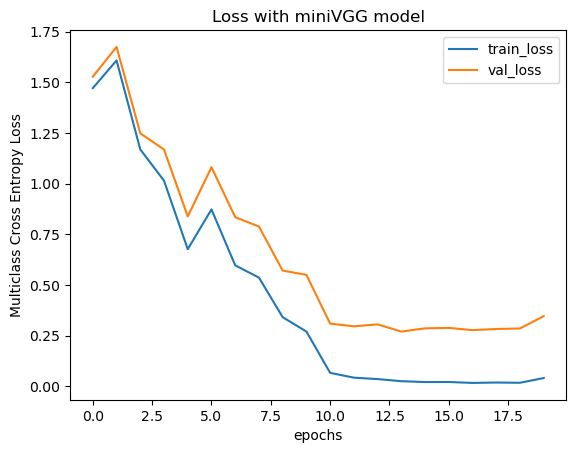

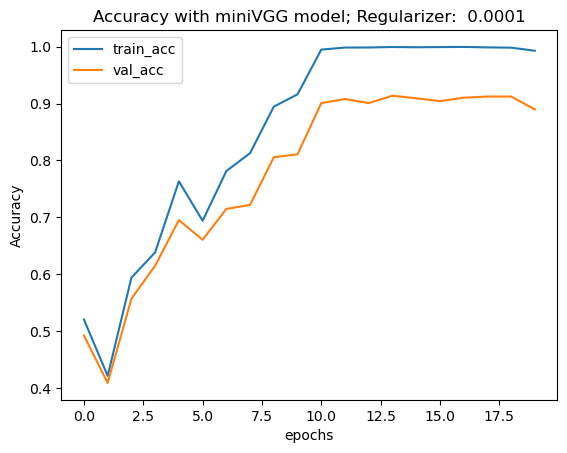

ResNet34(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ResidualBlock(
      (cnn1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (cnn2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (2): ResidualBlock(
      (cnn1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(

In [6]:
# Run training and validation loop
# Save the best model based on validation accuracy
n_epochs = 20
best_acc = -1
train_loss_history = []; train_acc_history = []
val_loss_history = []; val_acc_history = []
for epoch in range(n_epochs): # Iterate over epochs
    print(f"\nEpoch {epoch+1} of {n_epochs}")
    if epoch == n_epochs // 2:
        lr = optimizer.param_groups[0]['lr']
        print(f'Reducing learning rate from {lr} to {lr/4}')
        optimizer.param_groups[0]['lr'] /= 4
    train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
    train_loss, train_acc  = validate(model, train_eval_loader, criterion, device, tag='Train Eval') # Evaluate on Train data
    val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
    train_loss_history.append(train_loss); train_acc_history.append(train_acc)
    val_loss_history.append(val_loss); val_acc_history.append(val_acc)
    with open(f'train_loss_history{version_number}.pkl', 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(f'train_acc_history{version_number}.pkl', 'wb') as f:
        pickle.dump(train_acc_history, f)
    with open(f'val_loss_history{version_number}.pkl', 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(f'val_acc_history{version_number}.pkl', 'wb') as f:
        pickle.dump(val_acc_history, f)
    if val_acc > best_acc: # Save best model
        best_acc = val_acc
        torch.save(model.state_dict(), f"best_model_v{version_number}.pt") # saving model parameters ("state_dict") saves memory and is faster than saving the entire model

epochs = torch.arange(n_epochs)

# plot training and validation loss
plt.figure()
plt.plot(epochs, train_loss_history, label='train_loss')
plt.plot(epochs, val_loss_history, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.title(f'Loss with miniVGG model')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure()
plt.plot(epochs, train_acc_history, label='train_acc')
plt.plot(epochs, val_acc_history, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy with miniVGG model; Regularizer: {reg_val : 3.2g}')
plt.legend()
plt.show()


model.eval() # set model to evaluation mode 

# EVALUATION & ACCURACY

In [7]:
# Load the best model and evaluate on test set
model.load_state_dict(torch.load(f"best_model_v{version_number}.pt"))
test_loss, test_acc = validate(model, testloader, criterion, device)
print(f"Test accuracy: {test_acc:.4f}")

Val: 100%|██████████| 47/47 [01:31<00:00,  1.94s/batch, loss=0.323, acc=88.5]

Test accuracy: 0.8847


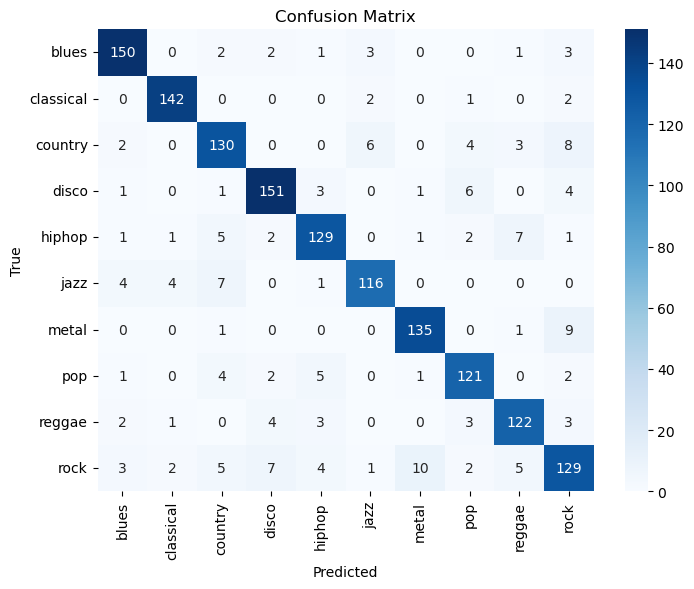

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
 
# model.load_state_dict(torch.load("best_model.pt"))

all_preds = []
all_labels = []
genre_list = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

for inputs, labels in testloader:  # Replace `testloader` with your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)  # Move to the appropriate device (GPU or CPU)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get the predictions
        _, preds = torch.max(outputs, 1)
        
        # Store all predictions and labels
        all_preds.extend(preds.cpu().numpy())  # Convert to numpy and add to list
        all_labels.extend(labels.cpu().numpy())  # Convert to numpy and add to list


# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = [genre_list[label] for label in all_labels]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_list, yticklabels=genre_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Listening for background noise sample (1 seconds)...
Background noise sample recording complete.
Recording music, get ready:
3
2
1
Listening for music sample (10 seconds)...
Music sample recording complete.

Saved denoised file as 'live_sample.wav'.


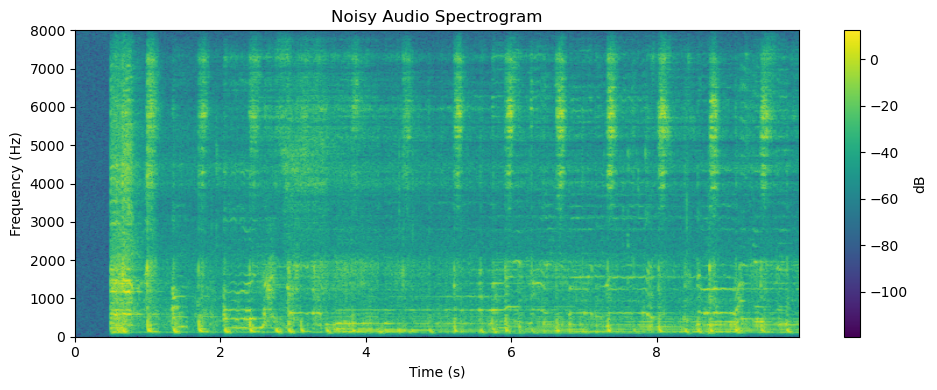

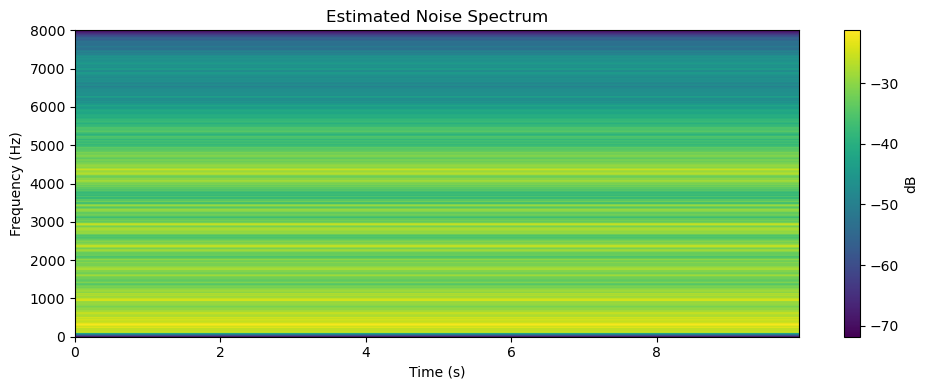

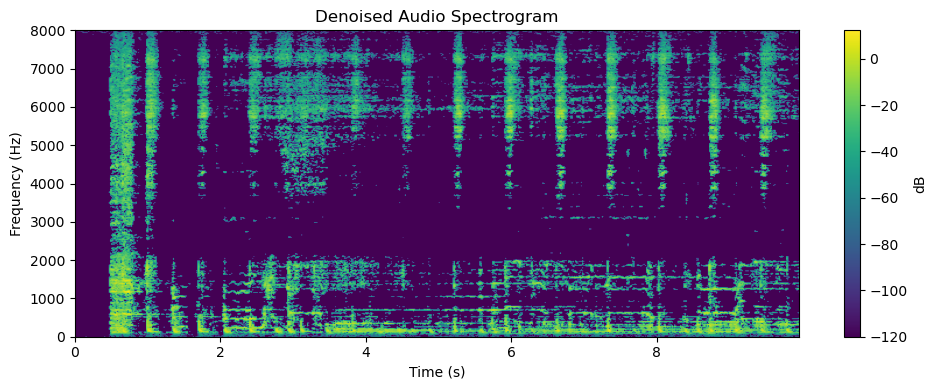

Saved: live_sample_spectrogram.png


In [29]:
import numpy as np
import sounddevice as sd
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt
import time
from spectrogram_generator import create_single_spectrogram

# --- Parameters ---
FS = 16000
NOISE_DURATION = 1
MUSIC_DURATION = 10
N_FFT = 1024
HOP_LENGTH = N_FFT // 4
WINDOW = signal.windows.hann(N_FFT)

# --- Functions ---
def record_audio(duration, fs, label="audio"):
    print(f"Listening for {label} ({duration} seconds)...")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print(f"{label.capitalize()} recording complete.")
    return audio.squeeze()

def stft(y, n_fft, hop_length, window):
    return np.array([np.fft.rfft(window * y[i:i+n_fft])
                     for i in range(0, len(y) - n_fft + 1, hop_length)]).T

def istft(Zxx, hop_length, window):
    n_fft = len(window)
    time_len = hop_length * (Zxx.shape[1] - 1) + n_fft
    y = np.zeros(time_len)
    W_sum = np.zeros(time_len)

    for i, frame in enumerate(Zxx.T):
        start = i * hop_length
        y[start:start+n_fft] += np.fft.irfft(frame) * window
        W_sum[start:start+n_fft] += window**2

    return y / (W_sum + 1e-10)

# spectral subtraction
# from separate noise-only sample (1 sec) and goal audio sample (10 sec)
# takes the STFT of the noise and the music and their magnitudes
# cleans by subtracting the noise from the music by magnitude and phase shifting
# perform inverse STFT on this phased subtraction to reconstruct the time-domain signal

def spectral_subtraction(noise_audio, noisy_audio, fs, n_fft, hop_length, window):
    # Estimate noise spectrum
    noise_stft = stft(noise_audio, n_fft, hop_length, window)
    noise_mag = np.abs(noise_stft).mean(axis=1, keepdims=True)

    # STFT of full signal
    noisy_stft = stft(noisy_audio, n_fft, hop_length, window)
    noisy_mag = np.abs(noisy_stft)
    phase = np.angle(noisy_stft)

    # Spectral subtraction
    clean_mag = np.maximum(noisy_mag - noise_mag, 0.0)
    clean_stft = clean_mag * np.exp(1j * phase)

    # Reconstruct time-domain signal
    denoised_audio = istft(clean_stft, hop_length, window)
    return denoised_audio, noisy_mag, noise_mag, clean_mag

# plotting just for demonstration
def plot_spectrogram(mag, title, fs, hop_length, n_fft):
    plt.figure(figsize=(10, 4))
    plt.imshow(20 * np.log10(mag + 1e-6), aspect='auto', origin='lower',
               extent=[0, mag.shape[1] * hop_length / fs, 0, fs / 2])
    plt.colorbar(label='dB')
    plt.title(title)
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

# --- Main Workflow ---
noise_audio = record_audio(NOISE_DURATION, FS, label="background noise sample")

print("Recording music, get ready:")
print("3")
time.sleep(1)
print("2")
time.sleep(1)
print("1")
time.sleep(1)

music_audio = record_audio(MUSIC_DURATION, FS, label="music sample")
wav.write("raw.wav", FS, (music_audio * 32767).astype(np.int16))

denoised, noisy_mag, noise_mag, clean_mag = spectral_subtraction(noise_audio, music_audio, FS, N_FFT, HOP_LENGTH, WINDOW)

# Normalize and save
denoised = denoised / np.max(np.abs(denoised))
wav.write("live_sample.wav", FS, (denoised * 32767).astype(np.int16))
print("\nSaved denoised file as 'live_sample.wav'.")

# --- Plot Spectrograms for demo ---
plot_spectrogram(noisy_mag, "Noisy Audio Spectrogram", FS, HOP_LENGTH, N_FFT)
plot_spectrogram(np.tile(noise_mag, (1, noisy_mag.shape[1])), "Estimated Noise Spectrum", FS, HOP_LENGTH, N_FFT)
plot_spectrogram(clean_mag, "Denoised Audio Spectrogram", FS, HOP_LENGTH, N_FFT)

# --- spectrogram creation for model ---
create_single_spectrogram("live_sample.wav", 3) # duration 3 set by the CNN.


In [35]:
from torchvision import transforms
from PIL import Image


genre_list = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

# Load the best model and evaluate on test set
model.load_state_dict(torch.load(f"best_model_v{version_number}.pt"))

model.eval()

# Label is 9 or 6
live_spectrogram_path = "live_sample_spectrogram.png"
live_spectrogram = Image.open(live_spectrogram_path)

tensor_img = transform(live_spectrogram)
tensor_img = tensor_img.unsqueeze(0)
print(tensor_img.shape)

outputs = model(tensor_img)
_, preds = torch.max(outputs, 1)
# print(preds)
print("Prediction: ",genre_list[int(preds.cpu().numpy())])
# print("Label: ", labels)

torch.Size([1, 1, 512, 512])
x: torch.Size([1, 8192])
Prediction:  blues


C:\Users\leduo\AppData\Local\Temp\ipykernel_20272\4269809086.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Prediction: ",genre_list[int(preds.cpu().numpy())])


# LOADING ACC & LOSS HISTORY

In [ ]:
with open(f'train_loss_history{version_number}.pkl', 'rb') as f:
    train_loss_history = pickle.load(f)
with open(f'train_acc_history{version_number}.pkl', 'rb') as f:
    train_acc_history = pickle.load(f)
with open(f'val_loss_history{version_number}.pkl', 'rb') as f:
    val_loss_history = pickle.load(f)
with open(f'val_acc_history{version_number}.pkl', 'rb') as f:
    val_acc_history = pickle.load(f)

CONFUSION MATRIX